In [2]:
import os
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Embedding,GRU,TimeDistributed, Dense, Dropout,Bidirectional,SimpleRNN

In [3]:
english_data_path='/content/drive/MyDrive/small_vocab_en.txt'
french_data_path='/content/drive/MyDrive/small_vocab_fr.txt'
with open(english_data_path, "r") as f:
  data=f.read()
english_sentences=data.split('\n')
with open(french_data_path, "r") as f:
  data=f.read()
french_sentences=data.split('\n')

In [4]:
english_sentences[:5]

['new jersey is sometimes quiet during autumn , and it is snowy in april .',
 'the united states is usually chilly during july , and it is usually freezing in november .',
 'california is usually quiet during march , and it is usually hot in june .',
 'the united states is sometimes mild during june , and it is cold in september .',
 'your least liked fruit is the grape , but my least liked is the apple .']

In [5]:
french_sentences[:5]

["new jersey est parfois calme pendant l' automne , et il est neigeux en avril .",
 'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .',
 'california est généralement calme en mars , et il est généralement chaud en juin .',
 'les états-unis est parfois légère en juin , et il fait froid en septembre .',
 'votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme .']

In [6]:
def tokenize(x):
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(x)
  return tokenizer.texts_to_sequences(x),tokenizer

In [7]:
english_sequences,english_tokenizer=tokenize(english_sentences)
french_sequences,french_tokenizer=tokenize(french_sentences)

In [8]:
english_sequences[:5]

[[17, 23, 1, 8, 67, 4, 39, 7, 3, 1, 55, 2, 44],
 [5, 20, 21, 1, 9, 62, 4, 43, 7, 3, 1, 9, 51, 2, 45],
 [22, 1, 9, 67, 4, 38, 7, 3, 1, 9, 68, 2, 34],
 [5, 20, 21, 1, 8, 64, 4, 34, 7, 3, 1, 57, 2, 42],
 [29, 12, 16, 13, 1, 5, 82, 6, 30, 12, 16, 1, 5, 83]]

In [9]:
french_sequences[:5]

[[35, 34, 1, 8, 67, 37, 11, 24, 6, 3, 1, 112, 2, 50],
 [4, 32, 31, 1, 12, 19, 2, 49, 6, 3, 95, 69, 2, 51],
 [101, 1, 12, 67, 2, 45, 6, 3, 1, 12, 21, 2, 41],
 [4, 32, 31, 1, 8, 269, 2, 41, 6, 3, 103, 19, 2, 48],
 [40, 13, 14, 16, 1, 10, 82, 5, 39, 13, 14, 1, 7, 83]]

In [10]:
def pad(x,length=None):
  return pad_sequences(x,maxlen=length,padding='post')

In [11]:
english_pad_sequences=pad(english_sequences)
french_pad_sequences=pad(french_sequences)

In [12]:
english_vocabulary=len(english_tokenizer.word_index)+1
french_vocabulary=len(french_tokenizer.word_index)+1
max_english_sequence_length=english_pad_sequences.shape[1]
max_french_sequence_length=french_pad_sequences.shape[1]

In [13]:
french_pad_sequences=french_pad_sequences.reshape(*french_pad_sequences.shape,1)


**Simple RNN model**
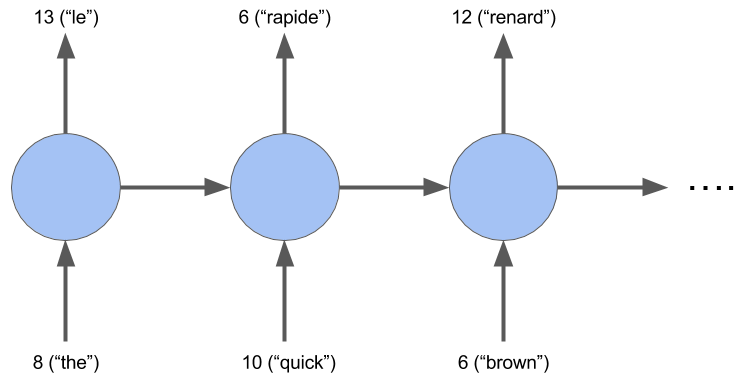

In [28]:
tmp_x=pad(english_pad_sequences,max_french_sequence_length)
tmp_x=tmp_x.reshape((-1,french_pad_sequences.shape[-2],1))

In [30]:
model_rnn=Sequential()
model_rnn.add(SimpleRNN(128,return_sequences=True,input_shape=tmp_x.shape[1:]))
model_rnn.add(TimeDistributed(Dense(1024,activation='relu')))
model_rnn.add(Dropout(0.5))
model_rnn.add(TimeDistributed(Dense(french_vocabulary,activation='softmax')))

In [31]:
learning_rate=0.005
model_rnn.compile(
    loss=sparse_categorical_crossentropy,
    optimizer=Adam(learning_rate),
    metrics=['accuracy']
)

In [32]:
model_rnn.fit(tmp_x,french_pad_sequences,batch_size=1024,epochs=10,validation_split=0.2)

Epoch 1/10
108/108 [==============================] - 7s 50ms/step - loss: 1.8062 - accuracy: 0.5651 - val_loss: 1.3105 - val_accuracy: 0.6329
Epoch 2/10
108/108 [==============================] - 5s 44ms/step - loss: 1.2530 - accuracy: 0.6385 - val_loss: 1.1226 - val_accuracy: 0.6568
Epoch 3/10
108/108 [==============================] - 5s 44ms/step - loss: 1.2765 - accuracy: 0.6368 - val_loss: 1.2268 - val_accuracy: 0.6446
Epoch 4/10
108/108 [==============================] - 5s 43ms/step - loss: 1.1803 - accuracy: 0.6503 - val_loss: 1.0644 - val_accuracy: 0.6705
Epoch 5/10
108/108 [==============================] - 4s 41ms/step - loss: 1.0920 - accuracy: 0.6640 - val_loss: 1.0163 - val_accuracy: 0.6864
Epoch 6/10
108/108 [==============================] - 5s 42ms/step - loss: 1.0464 - accuracy: 0.6728 - val_loss: 0.9658 - val_accuracy: 0.6939
Epoch 7/10
108/108 [==============================] - 6s 52ms/step - loss: 1.0084 - accuracy: 0.6802 - val_loss: 0.9337 - val_accuracy: 0.6994

In [14]:
tmp_x=pad(english_pad_sequences,max_french_sequence_length)
tmp_x=tmp_x.reshape((-1,french_pad_sequences.shape[-2]))

In [15]:
tmp_x.shape

(137861, 21)

**Simple RNN with Embedding**
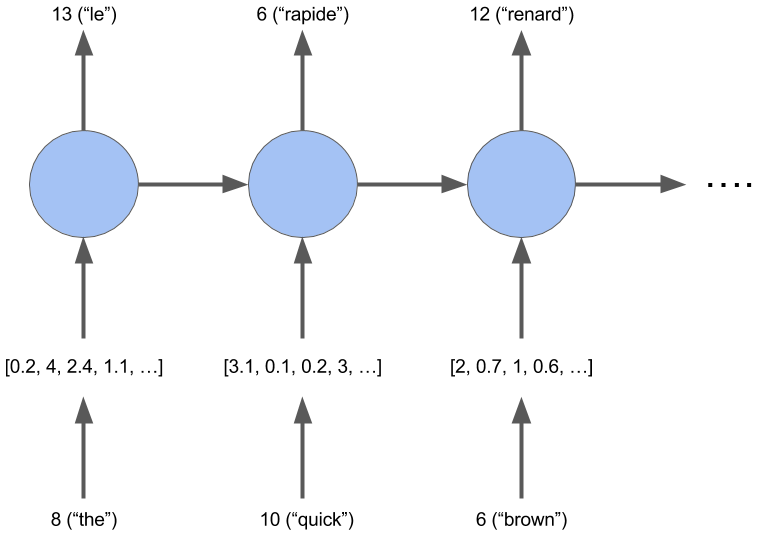

In [16]:
model=Sequential()
model.add(Embedding(english_vocabulary,256,input_length=tmp_x.shape[1],input_shape=tmp_x.shape[1:]))
model.add(SimpleRNN(256,return_sequences=True))
model.add(TimeDistributed(Dense(1024,activation='relu')))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(french_vocabulary,activation='softmax')))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 256)           51200     
                                                                 
 simple_rnn (SimpleRNN)      (None, 21, 256)           131328    
                                                                 
 time_distributed (TimeDist  (None, 21, 1024)          263168    
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 21, 1024)          0         
                                                                 
 time_distributed_1 (TimeDi  (None, 21, 345)           353625    
 stributed)                                                      
                                                                 
Total params: 799321 (3.05 MB)
Trainable params: 799321 

In [18]:
learning_rate=0.005
model.compile(
    loss=sparse_categorical_crossentropy,
    optimizer=Adam(learning_rate),
    metrics=['accuracy']
)

In [20]:
model.fit(tmp_x,french_pad_sequences,batch_size=1024,epochs=10,validation_split=0.2)

Epoch 1/10
108/108 [==============================] - 6s 55ms/step - loss: 0.3236 - accuracy: 0.8946 - val_loss: 0.2704 - val_accuracy: 0.9091
Epoch 2/10
108/108 [==============================] - 6s 53ms/step - loss: 0.2830 - accuracy: 0.9057 - val_loss: 0.2520 - val_accuracy: 0.9127
Epoch 3/10
108/108 [==============================] - 5s 50ms/step - loss: 0.2610 - accuracy: 0.9119 - val_loss: 0.2379 - val_accuracy: 0.9193
Epoch 4/10
108/108 [==============================] - 6s 60ms/step - loss: 0.2443 - accuracy: 0.9170 - val_loss: 0.2317 - val_accuracy: 0.9197
Epoch 5/10
108/108 [==============================] - 6s 53ms/step - loss: 0.2310 - accuracy: 0.9210 - val_loss: 0.2149 - val_accuracy: 0.9253
Epoch 6/10
108/108 [==============================] - 6s 56ms/step - loss: 0.2236 - accuracy: 0.9232 - val_loss: 0.2003 - val_accuracy: 0.9300
Epoch 7/10
108/108 [==============================] - 5s 51ms/step - loss: 0.2113 - accuracy: 0.9265 - val_loss: 0.2021 - val_accuracy: 0.9287

In [21]:
import numpy as np
def logits_to_texts(logits,tokenizer):
  index2word={id:word for word,id in tokenizer.word_index.items()}
  index2word[0]='PAD'
  return ' '.join([index2word[prediction] for prediction in np.argmax(logits,1)])

In [22]:
logits_to_texts(model.predict(tmp_x[:1])[0],french_tokenizer)

1/1 [==============================] - 0s 185ms/step


"new jersey est parfois calme en l' automne et il est neigeux en avril PAD PAD PAD PAD PAD PAD PAD"

1/1 [==============================] - 0s 26ms/step


array([[4.1293948e-08, 3.6913900e-07, 4.4647784e-08, ..., 3.3123149e-15,
        3.1085723e-14, 3.4286496e-15],
       [1.1235589e-09, 2.2282906e-07, 1.9546754e-08, ..., 8.0022894e-20,
        1.0178593e-18, 1.0544121e-19],
       [1.7577638e-09, 9.8695582e-01, 3.9959335e-07, ..., 7.9213223e-21,
        5.8003423e-20, 1.3491229e-21],
       ...,
       [9.9999964e-01, 7.8064999e-10, 2.1664745e-08, ..., 7.1769445e-24,
        1.5994162e-22, 3.8575352e-23],
       [9.9999988e-01, 2.3681129e-10, 6.5088592e-09, ..., 2.2790869e-25,
        6.3240478e-24, 1.3409213e-24],
       [1.0000000e+00, 7.6570701e-11, 2.0742827e-09, ..., 1.1859835e-26,
        3.9196253e-25, 7.5572030e-26]], dtype=float32)

**Bidirectional GPU**

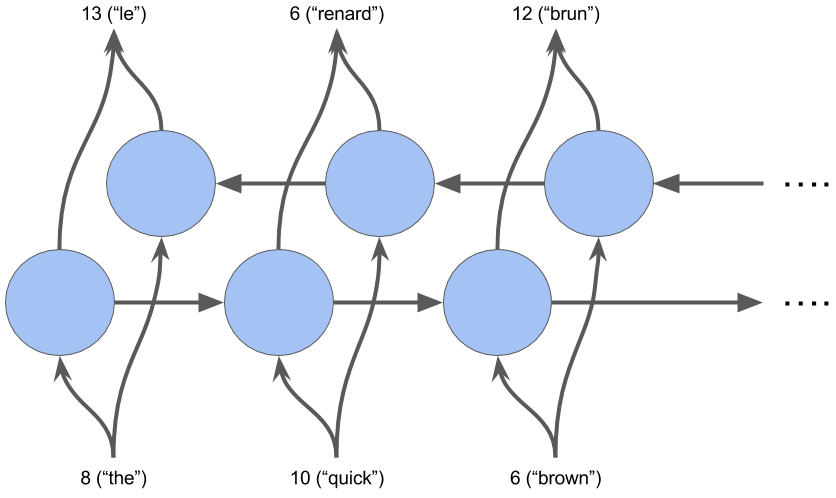

In [23]:
tmp_x=pad(english_pad_sequences,max_french_sequence_length)
tmp_x=tmp_x.reshape((-1,french_pad_sequences.shape[-2],1))

In [24]:
model1=Sequential()
model1.add(Bidirectional(GRU(128,return_sequences=True),input_shape=tmp_x.shape[1:]))
model1.add(TimeDistributed(Dense(1024,activation='relu')))
model1.add(Dropout(0.5))
model1.add(TimeDistributed(Dense(french_vocabulary,activation='softmax')))

In [25]:
learning_rate=0.005
model1.compile(
    loss=sparse_categorical_crossentropy,
    optimizer=Adam(learning_rate),
    metrics=['accuracy']
)

In [27]:
model1.fit(tmp_x,french_pad_sequences,batch_size=1024,epochs=10,validation_split=0.2)

Epoch 1/10
108/108 [==============================] - 6s 54ms/step - loss: 1.7441 - accuracy: 0.5775 - val_loss: 1.2246 - val_accuracy: 0.6469
Epoch 2/10
108/108 [==============================] - 5s 48ms/step - loss: 1.1798 - accuracy: 0.6534 - val_loss: 1.0504 - val_accuracy: 0.6737
Epoch 3/10
108/108 [==============================] - 5s 48ms/step - loss: 1.0466 - accuracy: 0.6764 - val_loss: 0.9342 - val_accuracy: 0.6972
Epoch 4/10
108/108 [==============================] - 5s 50ms/step - loss: 0.9572 - accuracy: 0.6904 - val_loss: 0.8630 - val_accuracy: 0.7095
Epoch 5/10
108/108 [==============================] - 5s 48ms/step - loss: 0.9016 - accuracy: 0.7004 - val_loss: 0.8202 - val_accuracy: 0.7202
Epoch 6/10
108/108 [==============================] - 5s 48ms/step - loss: 0.8607 - accuracy: 0.7077 - val_loss: 0.7780 - val_accuracy: 0.7256
Epoch 7/10
108/108 [==============================] - 5s 50ms/step - loss: 0.8226 - accuracy: 0.7163 - val_loss: 0.7454 - val_accuracy: 0.7333